In [1]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications.vgg16 import preprocess_input

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# get model
model = tf.keras.applications.VGG16(include_top=True, weights='imagenet', input_shape=(224, 224, 3))
model.summary()

553467904/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

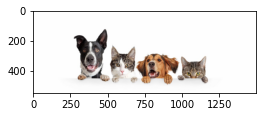

In [3]:
import matplotlib
import matplotlib.pyplot as plt

height = 550
width  = 1500

PATH = '/content/gdrive/My Drive/data/template-matching/'
query = kimage.load_img(PATH+'image7.jpg', target_size=(height, width))

plt.figure(figsize=(4,4))
plt.imshow(query)

In [4]:
# check model
for i in range(19,23):
  print(model.layers[i].name)

flatten
fc1
fc2
predictions


In [5]:
def compute_features(data):
  for i in range(1,19):
    data = model.layers[i](data)
  return data

In [6]:
def compute_prediction(data):
  for i in range(19,23):
    data = model.layers[i](data)
  return data

In [7]:
# compute features
query_np = kimage.img_to_array(query)
query_np = np.expand_dims(query_np, axis=0)
query_np = preprocess_input(query_np)

pred_query = compute_features(query_np)
print(pred_query.shape)

(1, 17, 46, 512)


In [8]:
# compute predictions
height = pred_query.shape[1]
width  = pred_query.shape[2]
depth  = pred_query.shape[3]

side = 7
prediction_data = []
for i in range(height-side+1):
  for j in range(width-side+1):
    patch = pred_query[:,i:i+side,j:j+side,:]
    patch = compute_prediction(patch)
    prediction_data.append( (tf.math.reduce_max(patch[0]).numpy(), i, j, tf.math.argmax(patch[0]).numpy()) )

In [9]:
def getKey(item):
    return item[0]

tp_s = sorted(prediction_data, key=getKey, reverse=True)
print(tp_s[:3])

[(0.8153709, 6, 8, 227), (0.811265, 6, 9, 227), (0.8090704, 10, 22, 207)]


In [10]:
labels = np.load(PATH+'imagenet1000_clsid_to_human.pkl', allow_pickle=True)
print(type(labels))
print(labels[227])

<class 'dict'>
kelpie


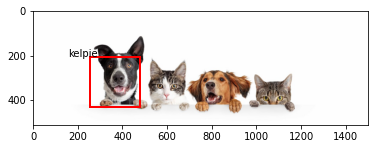

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = kimage.load_img(PATH+'image7.jpg', target_size=(510, 1500))

fig, ax = plt.subplots()
ax.imshow(im)

# Create a Rectangle patch
scale_height = height//pred_query.shape[1]
scale_width  = width//pred_query.shape[2]
for i in range(1): 
  rect = patches.Rectangle((tp_s[i][2]*scale_width,tp_s[i][1]*scale_height), 224, 224, linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  plt.text(tp_s[i][2]*scale_width-100, tp_s[i][1]*scale_height, labels[tp_s[i][3]])

plt.show()

In [ ]:
from scipy.spatial import distance
a = (1, 2)
b = (4, 5)
dst = distance.euclidean(a, b)
print(dst)

4.242640687119285


In [ ]:
def check_duplication(i,j,data):
  result = False

  coord1 = (i,j)
  
  length = len(data)
  for k in range(length):
    coord2 = (data[k][1], data[k][2])
    dst = distance.euclidean(coord1, coord2)

    if (dst < 5):
      result = True
      break
  
  return result

In [ ]:
from scipy.spatial import distance

# remove duplication
def remove_duplication(data):
  result = []

  length = len(data)
  for k in range(length-1):
    duplicated = check_duplication(data[k][1], data[k][2], result)
    
    if (duplicated==False and data[k][0]>0.5):
      result.append( data[k] )
    
    
  return result

In [ ]:
print(len(tp_s))
print(tp_s[:3])
result = remove_duplication(tp_s)
print(len(result))
print(result)

360
[(0.84278953, 6, 8, 227), (0.8218838, 6, 9, 227), (0.8126994, 5, 9, 227)]
4
[(0.84278953, 6, 8, 227), (0.7499764, 0, 9, 195), (0.6260014, 8, 15, 281), (0.5418579, 8, 22, 207)]


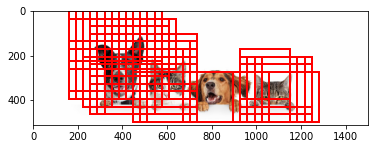

In [ ]:
# Show all with a threshold
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = kimage.load_img(PATH+'image7.jpg', target_size=(510, 1500))

fig, ax = plt.subplots()
ax.imshow(im)

length = len(tp_s)

# Create a Rectangle patch
scale_height = 510//15
scale_width  = 1500//46
for i in range(length): 
  if (tp_s[i][0] > 0.4):
    rect = patches.Rectangle((tp_s[i][2]*scale_width,tp_s[i][1]*scale_height), 224, 224, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    #plt.text(tp_s[i][2]*scale_width-100, tp_s[i][1]*scale_height, labels[tp_s[i][3]])

plt.show()

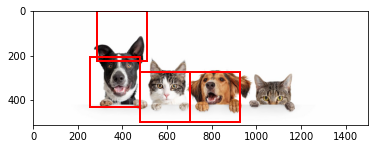

In [ ]:
# Show all with a threshold
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = kimage.load_img(PATH+'image7.jpg', target_size=(510, 1500))

fig, ax = plt.subplots()
ax.imshow(im)

length = len(result)

# Create a Rectangle patch
scale_height = 510//15
scale_width  = 1500//46
for i in range(length):   
  rect = patches.Rectangle((result[i][2]*scale_width,result[i][1]*scale_height), 224, 224, linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  #plt.text(result[i][2]*scale_width-100, result[i][1]*scale_height, labels[result[i][3]])

plt.show()